# Starlink-32101 - Covariance Analysis
Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
This example highlights the basic steps of setting up an orbit estimation routine. In particular, note that within this example we will focus on how to set up the estimation of a covariance matrix and its propagation over the course of the spacecraft's orbit. For the full estimation of the initial state, drag coefficient, and radiation pressure coefficient of the spacecraft see TBD-LINK.

Have you already followed the full estimation example? Then you might want to skip the first part of this example dealing with the setup of all relevant (environment, propagation, and estimation) modules and dive straight in to the propagation of the [covariance](#covariance_section).

To simulate the orbit of a spacecraft, we will fall back and reiterate on all aspects of orbit propagation that are important within the scope of orbit estimation. Further, we will highlight all relevant features of modelling a tracking station on Earth. Using this station, we will simulate a tracking routine of the spacecraft using a series of open-loop Doppler range-rate measurements at 1 mm/s every 60 seconds. To assure an uninterrupted line-of-sight between the station and the spacecraft, a minimum elevation angle of more than 15 degrees above the horizon - as seen from the station - will be imposed as constraint on the simulation of observations.

FINAL TEXT COVARIANCE ANALYSIS?

## Import statements
Typically - in the most pythonic way - all required modules are imported at the very beginning.

Some standard modules are first loaded: `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported. Most notably, the `estimation`, `estimation_setup`, and `observations` modules will be used and demonstrated within this example.

In [231]:
# Load required standard modules
import numpy as np
from matplotlib import pyplot as plt

# Load required tudatpy modules
from tudatpy import constants
from tudatpy.interface import spice
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment
from tudatpy.numerical_simulation import environment_setup
from tudatpy.numerical_simulation import propagation_setup
from tudatpy.numerical_simulation import estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.astro.time_conversion import DateTime
from tudatpy.astro import element_conversion

## Configuration
First, NAIF's `SPICE` kernels are loaded, to make the positions of various bodies such as the Earth, the Sun, or the Moon known to `tudatpy`.

Subsequently, the start and end epoch of the simulation are defined. Note that using `tudatpy`, the times are generally specified in seconds since J2000. Hence, setting the start epoch to `0` corresponds to the 1st of January 2000. The end epoch specifies a total duration of the simulation of three days.

For more information on J2000 and the conversion between different temporal reference frames, please refer to the API documentation of the [`time_conversion module`](https://tudatpy.readthedocs.io/en/latest/time_conversion.html).

In [232]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start and end epochs
simulation_start_epoch = DateTime(2024, 8, 28).epoch()
simulation_end_epoch   = DateTime(2024, 9, 10).epoch()
observation_start_epoch_1 = DateTime(2024, 8, 30).epoch()
observation_end_epoch_1   = DateTime(2024, 9, 2).epoch()
observation_start_epoch_2   = DateTime(2024, 9, 6).epoch()
observation_end_epoch_2   = DateTime(2024, 9, 7).epoch()

## Set up the environment
We will now create and define the settings for the environment of our simulation. In particular, this covers the creation of (celestial) bodies, vehicle(s), and environment interfaces.

### Create the main bodies
To create the systems of bodies for the simulation, one first has to define a list of strings of all bodies that are to be included. Note that the default body settings (such as atmosphere, body shape, rotation model) are taken from the `SPICE` kernel.

These settings, however, can be adjusted. Please refer to the [Available Environment Models](https://tudat-space.readthedocs.io/en/latest/_src_user_guide/state_propagation/environment_setup/create_models/available.html#available-environment-models) in the user guide for more details.

Finally, the system of bodies is created using the settings. This system of bodies is stored into the variable `bodies`.

In [233]:
# Create default body settings for "Sun", "Earth", "Moon", "Mars", and "Venus"
bodies_to_create = ["Sun", "Earth", "Moon", "Mars", "Venus"]

# Create default body settings for bodies_to_create, with "Earth"/"J2000" as the global frame origin and orientation
global_frame_origin = "Earth"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

### Create the vehicle and its environment interface
We will now create the satellite - called Starlink-32101 - for which an orbit will be simulated. Using an `empty_body` as a blank canvas for the satellite, we define mass of 400kg, a reference area (used both for aerodynamic and radiation pressure) of 4m$^2$, and a aerodynamic drag coefficient of 1.2. Idem for the radiation pressure coefficient. Finally, when setting up the radiation pressure interface, the Earth is set as a body that can occult the radiation emitted by the Sun.

In [234]:
# Create vehicle objects.
bodies.create_empty_body("Starlink-32101")
bodies.get("Starlink-32101").mass = 260

# Create aerodynamic coefficient interface settings
reference_area = (4*0.3*0.1+2*0.1*0.1)/4  # Average projection area of a 3U CubeSat
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area, [drag_coefficient, 0.0, 0.0]
)
# Add the aerodynamic interface to the environment
environment_setup.add_aerodynamic_coefficient_interface(bodies, "Starlink-32101", aero_coefficient_settings)

# Create radiation pressure settings
reference_area_radiation = (4*0.3*0.1+2*0.1*0.1)/4  # Average projection area of a 3U CubeSat
radiation_pressure_coefficient = 1.2
occulting_bodies = ["Earth"]
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
    "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies
)
# Add the radiation pressure interface to the environment
environment_setup.add_radiation_pressure_interface(bodies, "Starlink-32101", radiation_pressure_settings)

## Set up the propagation
Having the environment created, we will define the settings for the propagation of the spacecraft. First, we have to define the body to be propagated - here, the spacecraft - and the central body - here, Earth - with respect to which the state of the propagated body is defined.

In [235]:
# Define bodies that are propagated
bodies_to_propagate = ["Starlink-32101"]

# Define central bodies of propagation
central_bodies = ["Earth"]

### Create the acceleration model
Subsequently, all accelerations (and there settings) that act on `Starlink-32101` have to be defined. In particular, we will consider:
* Gravitational acceleration using a spherical harmonic approximation up to 8th degree and order for Earth.
* Aerodynamic acceleration for Earth.
* Gravitational acceleration using a simple point mass model for:
    - The Sun
    - The Moon
    - Mars
* Radiation pressure experienced by the spacecraft - shape-wise approximated as a spherical cannonball - due to the Sun.

The defined acceleration settings are then applied to `Starlink-32101` by means of a dictionary, which is finally used as input to the propagation setup to create the acceleration models.

In [236]:
# Define the accelerations acting on Starlink-32101
accelerations_settings_Starlink_32101 = dict(
    Sun=[
        propagation_setup.acceleration.cannonball_radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Mars=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Moon=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=[
        propagation_setup.acceleration.spherical_harmonic_gravity(8, 8),
        propagation_setup.acceleration.aerodynamic()
    ])

# Create global accelerations dictionary
acceleration_settings = {"Starlink-32101": accelerations_settings_Starlink_32101}

# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies)

Warning, you are using the deprecated (as of tudatpy v0.8) version of the cannonball radiation pressure model, the interface you are using will be dropped from v0.9 onwards. To learn how to convert your code to the new interfaces, and be able to use the powerful new radiation pressure framework, see https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/propagation_setup/translational/radiation_pressure_acceleration.html#backwards-compatibility


### Define the initial state
Realise that the initial state of the spacecraft always has to be provided as a cartesian state - i.e. in the form of a list with the first three elements representing the initial position, and the three remaining elements representing the initial velocity.

Within this example, we will retrieve the initial state of Starlink-32101 using its Two-Line-Elements (TLE) the date of its launch (April the 28th, 2008). The TLE strings are obtained from [www.n2yo.com](https://www.n2yo.com/satellite/?s=60447).

In [237]:
# Retrieve the initial state of Starlink-32101 using Two-Line-Elements (TLEs)
Starlink_tle = environment.Tle(
    "1 60447U 24144Y   24239.91667824 -.00652022  00000-0 -25508-2 0  9990",
"2 60447  53.1498 303.6008 0000548  88.4809  23.6264 15.87779028  3478"
)
Starlink_ephemeris = environment.TleEphemeris( "Earth", "J2000", Starlink_tle, False )
initial_state = Starlink_ephemeris.cartesian_state( simulation_start_epoch )

### Create the integrator settings
For the problem at hand, we will use an RKF78 integrator with a fixed step-size of 60 seconds. This can be achieved by tweaking the implemented RKF78 integrator with variable step-size such that both the minimum and maximum step-size is equal to 60 seconds and a tolerance of 1.0

In [238]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.\
    runge_kutta_fixed_step_size(initial_time_step=60.0,
                                coefficient_set=propagation_setup.integrator.CoefficientSets.rkdp_87)

### Create the propagator settings
By combining all of the above-defined settings we can define the settings for the propagator to simulate the orbit of `Starlink-32101` around Earth. A termination condition needs to be defined so that the propagation stops as soon as the specified end epoch is reached. Finally, the translational propagator's settings are created.

In [239]:
# Create termination settings
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch,
    integrator_settings,
    termination_condition
)

## Set up the observations
Having set the underlying dynamical model of the simulated orbit, we can define the observational model. Generally, this entails the addition all required ground stations, the definition of the observation links and types, as well as the precise simulation settings.

### Add a ground station
Trivially, the simulation of observations requires the extension of the current environment by at least one observer - a ground station. For this example, we will model a single ground station located in Delft, Netherlands, at an altitude of 0m, 52.00667°N, 4.35556°E.

More information on how to use the `add_ground_station()` function can be found in the respective [API documentation](https://tudatpy.readthedocs.io/en/latest/environment_setup.html#tudatpy.numerical_simulation.environment_setup.add_ground_station).

In [240]:
# Define the position of the ground station on Earth
station_altitude = 0.0
delft_latitude = np.deg2rad(52.00667)
delft_longitude = np.deg2rad(4.35556)

# Add the ground station to the environment
environment_setup.add_ground_station(
    bodies.get_body("Earth"),
    "TrackingStation",
    [station_altitude, delft_latitude, delft_longitude],
    element_conversion.geodetic_position_type)

### Define Observation Links and Types
To establish the links between our ground station and `Starlink-32101`, we will make use of the [observation module](https://py.api.tudat.space/en/latest/observation.html#observation) of tudat. During th link definition, each member is assigned a certain function within the link, for instance as "transmitter", "receiver", or "reflector". Once two (or more) members are connected to a link, they can be used to simulate observations along this particular link. The precise type of observation made along this link - e.g., range, range-rate, angular position, etc. - is then determined by the chosen observable type.

To fully define an observation model for a given link, we have to create a list of the observation model settings of all desired observable types and their associated links. This list will later be used as input to the actual estimator object.

Each observable type has its own function for creating observation model settings - in this example we will use the `one_way_doppler_instantaneous()` function to model a series of one-way open-loop (i.e. instantaneous) Doppler observations. Realise that the individual observation model settings can also include corrective models or define biases for more advanced use-cases.

In [241]:
# Define the uplink link ends for one-way observable
link_ends = dict()
link_ends[observation.transmitter] = observation.body_reference_point_link_end_id("Earth", "TrackingStation")
link_ends[observation.receiver] = observation.body_origin_link_end_id("Starlink-32101")

# Create observation settings for each link/observable
link_definition = observation.LinkDefinition(link_ends)
observation_settings_list = [observation.one_way_doppler_instantaneous(link_definition)]

### Define Observation Simulation Settings
We now have to define the times at which observations are to be simulated. To this end, we will define the settings for the simulation of the individual observations from the previously defined observation models. Bear in mind that these observation simulation settings are not to be confused with the ones to be used when setting up the estimator object, as done just above.

Finally, for each observation model, the observation simulation settings set the times at which observations are simulated and defines the viability criteria and noise of the observation. Realise that the latter is technically not needed within the scope of a covariance analysis but for the sake of completeness (and with eye for the estimation example re-using this code) we have opted to nonetheless include it already.

Note that the actual simulation of the observations requires `Observation Simulators`, which are created automatically by the `Estimator` object. Hence, one cannot simulate observations before the creation of an estimator.

1
Calculating residuals and partials 45
2
Calculating residuals and partials 60
3
Calculating residuals and partials 191
[3.09645885e-01 1.22413676e-01 4.19168069e-01 1.53177249e-04
 5.14371604e-04 2.42868841e-04 1.05025647e+07 6.74233497e-05]
[1.41047505e-01 9.62712683e-02 2.15747129e-01 7.84751520e-05
 2.03973957e-04 1.52234593e-04 8.85522956e+06 6.97828500e-06]
[7.19672376e-02 5.30238934e-02 1.02786785e-01 4.21191339e-05
 8.13165748e-05 7.63594625e-05 5.00491748e+06 1.43778680e-06]


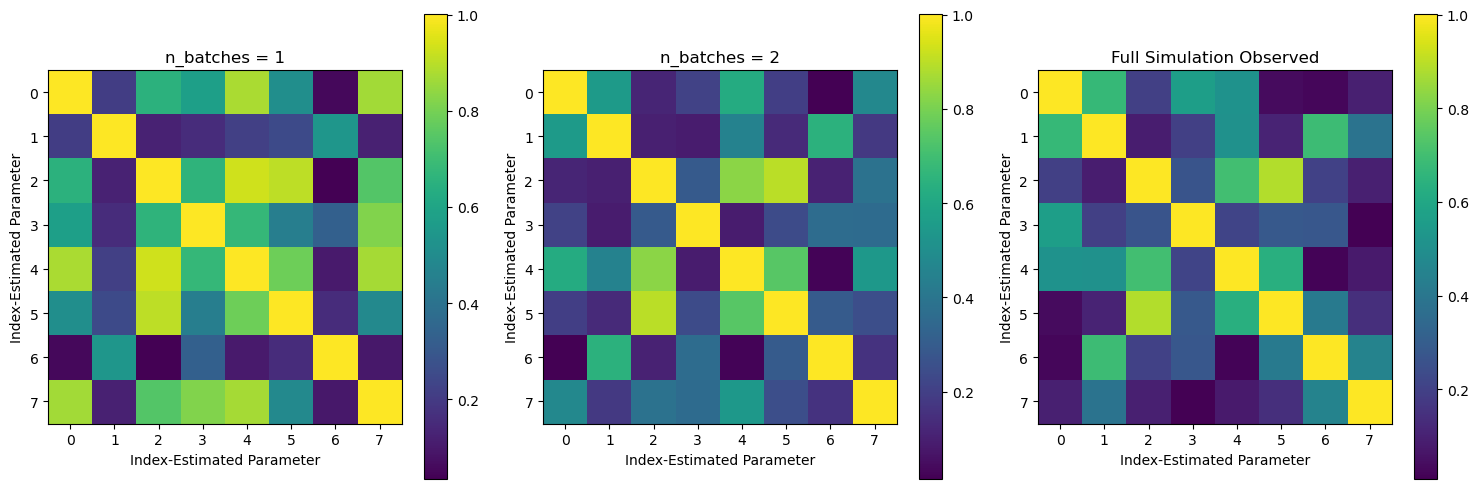

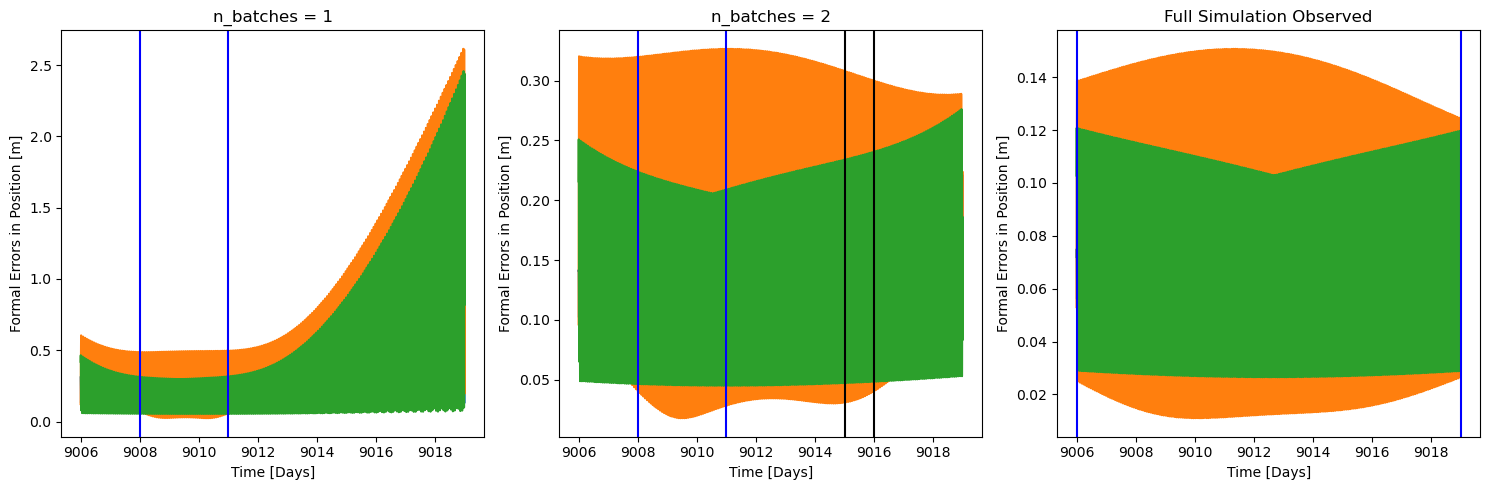

In [281]:
# Define observation simulation times for each link (separated by steps of 1 minute)
simulation_times = np.arange(simulation_start_epoch, simulation_end_epoch, 60.0)

observation_times_1 = np.arange(observation_start_epoch_1, observation_end_epoch_1, 60.0)
observation_times_2 = np.arange(observation_start_epoch_2, observation_end_epoch_2, 60.0)
observation_times_3 = simulation_times


output_times = simulation_times
covariance_output_list = []
formal_errors_list = []

for n_batches in [1,2,3]:
    print(n_batches)
    if n_batches == 1:
        observation_times = observation_times_1
    elif n_batches == 2:
        observation_times = np.concatenate((observation_times_1, observation_times_2))
    else:
        observation_times = observation_times_3

    observation_simulation_settings = observation.tabulated_simulation_settings(
        observation.one_way_instantaneous_doppler_type,
        link_definition,
        observation_times
    )

    # Add noise levels of roughly 1.0E-3 [m/s] and add this as Gaussian noise to the observation
    noise_level = 1.0E-3
    observation.add_gaussian_noise_to_observable(
        [observation_simulation_settings],
        noise_level,
        observation.one_way_instantaneous_doppler_type
    )

    # Create viability settings
    viability_setting = observation.elevation_angle_viability(["Earth", "TrackingStation"], np.deg2rad(15))
    observation.add_viability_check_to_all(
        [observation_simulation_settings],
        [viability_setting]
    )
    # Create the estimator
    estimator = numerical_simulation.Estimator(
        bodies,
        parameters_to_estimate,
        observation_settings_list,
        propagator_settings)
        # Simulate required observations
    simulated_observations = estimation.simulate_observations(
        [observation_simulation_settings],
        estimator.observation_simulators,
        bodies)
    # Create input object for covariance analysis
    covariance_input = estimation.CovarianceAnalysisInput(
        simulated_observations)
    
    # Set methodological options
    covariance_input.define_covariance_settings(
        reintegrate_variational_equations=False)
    
    # Define weighting of the observations in the inversion
    weights_per_observable = {estimation_setup.observation.one_way_instantaneous_doppler_type: noise_level ** -2}
    covariance_input.set_constant_weight_per_observable(weights_per_observable)

    # Perform the covariance analysis
    covariance_output = estimator.compute_covariance(covariance_input)
    covariance_output_list.append(covariance_output)

    initial_covariance = covariance_output.covariance
    state_transition_interface = estimator.state_transition_interface
    
    # Propagate formal errors over the course of the orbit
    propagated_formal_errors = estimation.propagate_formal_errors_split_output(
        initial_covariance=initial_covariance,
        state_transition_interface=state_transition_interface,
        output_times=output_times)
    # Split tuple into epochs and formal errors
    epochs = np.array(propagated_formal_errors[0])
    formal_errors = np.array(propagated_formal_errors[1])
    formal_errors_list.append(formal_errors)

# Print the covariance matrix
print(covariance_output_list[0].formal_errors)
print(covariance_output_list[1].formal_errors)
print(covariance_output_list[2].formal_errors)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Create the heatmaps and add colorbars
im0 = axs[0].imshow(np.abs(covariance_output_list[0].correlations), aspect='auto', interpolation='none')
axs[0].set_title('n_batches = 1')
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(np.abs(covariance_output_list[1].correlations), aspect='auto', interpolation='none')
axs[1].set_title('n_batches = 2')
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(np.abs(covariance_output_list[2].correlations), aspect='auto', interpolation='none')
axs[2].set_title('Full Simulation Observed')
fig.colorbar(im2, ax=axs[2])

for ax in axs.flat:
    ax.set(xlabel='Index-Estimated Parameter', ylabel='Index-Estimated Parameter')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


fig2, axs2 = plt.subplots(1, 3, figsize=(15, 5))

# Create the heatmaps and add colorbars
axs2[0].plot(output_times / (24*3600), formal_errors_list[0][:, 0], label=r"$x$")
axs2[0].plot(output_times / (24*3600), formal_errors_list[0][:, 1], label=r"$y$")
axs2[0].plot(output_times / (24*3600), formal_errors_list[0][:, 2], label=r"$z$")
axs2[0].axvline(observation_start_epoch_1/(24*3600), color = 'b', label = 'Obs. Window')
axs2[0].axvline(observation_end_epoch_1/(24*3600), color = 'b')
axs2[0].set_title('n_batches = 1')

axs2[1].plot(output_times / (24*3600), formal_errors_list[1][:, 0], label=r"$x$")
axs2[1].plot(output_times / (24*3600), formal_errors_list[1][:, 1], label=r"$y$")
axs2[1].plot(output_times / (24*3600), formal_errors_list[1][:, 2], label=r"$z$")
axs2[1].axvline(observation_start_epoch_1/(24*3600), color = 'b', label = '1st Obs. Window')
axs2[1].axvline(observation_end_epoch_1/(24*3600), color = 'b')
axs2[1].axvline(observation_start_epoch_2/(24*3600), color = 'k', label = '2nd Obs. Window')
axs2[1].axvline(observation_end_epoch_2/(24*3600), color = 'k')
axs2[1].set_title('n_batches = 2')

axs2[2].plot(output_times / (24*3600), formal_errors_list[2][:, 0], label=r"$x$")
axs2[2].plot(output_times / (24*3600), formal_errors_list[2][:, 1], label=r"$y$")
axs2[2].plot(output_times / (24*3600), formal_errors_list[2][:, 2], label=r"$z$")
axs2[2].axvline(simulation_start_epoch/(24*3600), color = 'b', label = 'Obs. Window')
axs2[2].axvline(simulation_end_epoch/(24*3600), color = 'b')
axs2[2].set_title('Full Simulation Observed')

for ax in axs2.flat:
    ax.set(xlabel='Time [Days]', ylabel='Formal Errors in Position [m]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs2.flat:
    ax.set_aspect('auto')

plt.tight_layout()
plt.show()


## Set up the estimation
Using the defined models for the environment, the propagator, and the observations, we can finally set the actual presentation up. In particular, this consists of defining all parameter that should be estimated, the creation of the estimator, and the simulation of the observations.

### Defining the parameters to estimate
For this example estimation, we decided to estimate the initial state of `Starlink-32101`, its drag coefficient, and the gravitational parameter of Earth. A comprehensive list of parameters available for estimation is provided in the FIX LINK.

In [253]:
    # Setup parameters settings to propagate the state transition matrix
    parameter_settings = estimation_setup.parameter.initial_states(propagator_settings, bodies)
    
    # Add estimated parameters to the sensitivity matrix that will be propagated
    parameter_settings.append(estimation_setup.parameter.gravitational_parameter("Earth"))
    parameter_settings.append(estimation_setup.parameter.constant_drag_coefficient("Starlink-32101"))
    
    # Create the parameters that will be estimated
    parameters_to_estimate = estimation_setup.create_parameter_set(parameter_settings, bodies)

### Creating the Estimator object
Ultimately, the `Estimator` object consolidates all relevant information required for the estimation of any system parameter:
    * the environment (bodies)
    * the parameter set (parameters_to_estimate)
    * observation models (observation_settings_list)
    * dynamical, numerical, and integrator setup (propagator_settings)

Underneath its hood, upon creation, the estimator automatically takes care of setting up the relevant Observation Simulator and Variational Equations which will subsequently be required for the simulation of observations and the estimation of parameters, respectively.

In [254]:
    # Create the estimator
    estimator = numerical_simulation.Estimator(
        bodies,
        parameters_to_estimate,
        observation_settings_list,
        propagator_settings)

### Perform the observations simulation
Using the created `Estimator` object, we can perform the simulation of observations by calling its [`simulation_observations()`](https://py.api.tudat.space/en/latest/estimation.html#tudatpy.numerical_simulation.estimation.simulate_observations) function. Note that to know about the time settings for the individual types of observations, this function makes use of the earlier defined observation simulation settings.

In [255]:
    # Simulate required observations
    simulated_observations = estimation.simulate_observations(
        [observation_simulation_settings],
        estimator.observation_simulators,
        bodies)

<a id='covariance_section'></a>

## Perform the covariance analysis
Having simulated the observations and created the `Estimator` object - containing the variational equations for the parameters to estimate - we have defined everything to conduct the actual estimation. Realise that up to this point, we have not yet specified whether we want to perform a covariance analysis or the full estimation of all parameters. It should be stressed that the general setup for either path to be followed is entirely identical.

### Set up the inversion
To set up the inversion of the problem, we collect all relevant inputs in the form of a covariance input object and define some basic settings of the inversion. Most crucially, this is the step where we can account for different weights - if any - of the different observations, to give the estimator knowledge about the quality of the individual types of observations.

In [256]:
    # Create input object for covariance analysis
    covariance_input = estimation.CovarianceAnalysisInput(
        simulated_observations)
    
    # Set methodological options
    covariance_input.define_covariance_settings(
        reintegrate_variational_equations=False)
    
    # Define weighting of the observations in the inversion
    weights_per_observable = {estimation_setup.observation.one_way_instantaneous_doppler_type: noise_level ** -2}
    covariance_input.set_constant_weight_per_observable(weights_per_observable)

### Propagate the covariance matrix
Using the just defined inputs, we can ultimately run the computation of our covariance matrix. Printing the resulting formal errors will give us the diagonal entries of the matrix - while the first six entries represent the uncertainties in the (cartesian) initial state, the seventh and eighth are the errors associated with the gravitational parameter of Earth and the aerodynamic drag coefficient, respectively.

In [257]:
    # Perform the covariance analysis
    covariance_output = estimator.compute_covariance(covariance_input)

Calculating residuals and partials 191


In [258]:
    # Print the covariance matrix
    print(covariance_output.formal_errors)

[7.19672376e-02 5.30238934e-02 1.02786785e-01 4.21191339e-05
 8.13165748e-05 7.63594625e-05 5.00491748e+06 1.43778680e-06]


## Results post-processing
Finally, to further process the obtained data, one can - exemplary - plot the correlation between the individual estimated parameters, or the behaviour of the formal error over time.

### Correlation
When dealing with the results of covariance analyses - as a measure of how the estimated variable differs from the 'thought' true value - it is important to underline that the correlation between the parameters is another important aspect to take into consideration. In particular, correlation describes how two parameters are related with each other. Typically, a value of 1.0 indicates entirely correlated elements (thus always present on the diagonal, indicating the correlation of an element with itself), a value of 0.0 indicates perfectly uncorrelated elements.

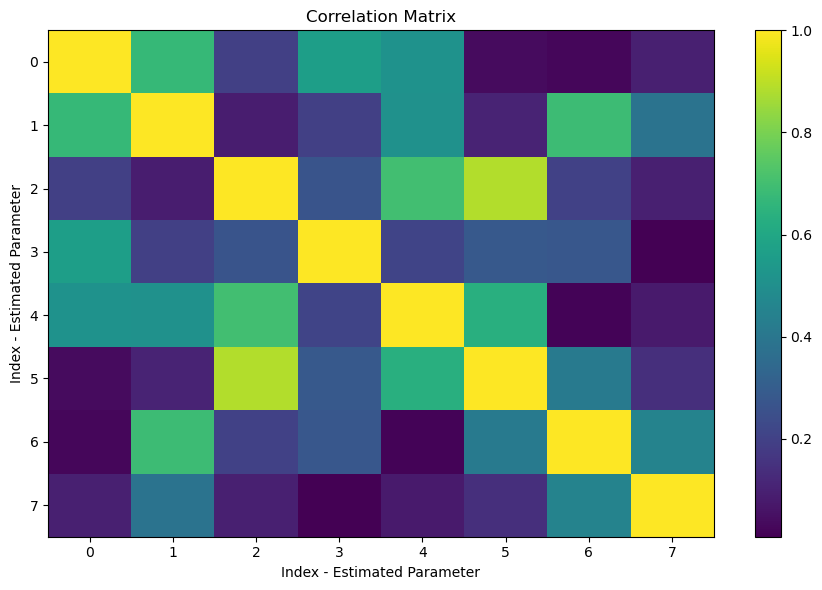

In [259]:
plt.figure(figsize=(9, 6))

plt.imshow(np.abs(covariance_output.correlations), aspect='auto', interpolation='none')
plt.colorbar()

plt.title("Correlation Matrix")
plt.xlabel("Index - Estimated Parameter")
plt.ylabel("Index - Estimated Parameter")

plt.tight_layout()
plt.show()

### Propagated Formal Errors

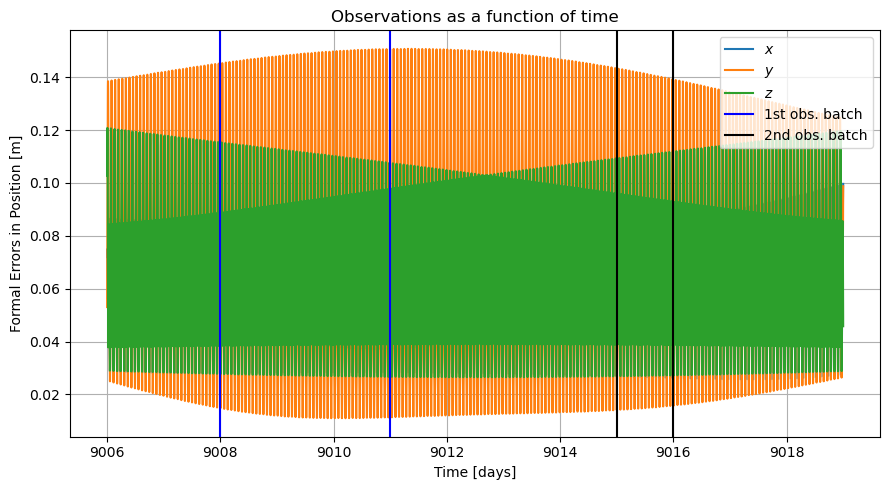

In [260]:
initial_covariance = covariance_output.covariance
state_transition_interface = estimator.state_transition_interface
output_times = simulation_times

# Propagate formal errors over the course of the orbit
propagated_formal_errors = estimation.propagate_formal_errors_split_output(
    initial_covariance=initial_covariance,
    state_transition_interface=state_transition_interface,
    output_times=output_times)
# Split tuple into epochs and formal errors
epochs = np.array(propagated_formal_errors[0])
formal_errors = np.array(propagated_formal_errors[1])

plt.figure(figsize=(9, 5))
plt.title("Observations as a function of time")
plt.plot(output_times / (24*3600), formal_errors[:, 0], label=r"$x$")
plt.plot(output_times / (24*3600), formal_errors[:, 1], label=r"$y$")
plt.plot(output_times / (24*3600), formal_errors[:, 2], label=r"$z$")
plt.axvline(observation_start_epoch_1/(24*3600), color = 'b', label = '1st obs. batch')
plt.axvline(observation_end_epoch_1/(24*3600), color = 'b')

plt.axvline(observation_start_epoch_2/(24*3600), color = 'k', label = '2nd obs. batch')
plt.axvline(observation_end_epoch_2/(24*3600), color = 'k')

plt.xlabel("Time [days]")
plt.ylabel("Formal Errors in Position [m]")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [262]:
print(n_batches)

3
